In [46]:
# Could be CoroNet, CovidCNN  (Haque), EMCNet, DarkNet # To be done
MODEL_NAME = 'EMCNet'

# Define hyperparameters
BATCH_SIZE = 32
LEARNING_RATE = 0.01
NUM_EPOCHS = 100

DATA_PATH = "/content/data_split/"
UNZIP_LOC = '/content/data/'
ZIPFILE = 'dataset.zip'

MODEL_ROOT = '/content/models/'


Setup the packages that are missing in the Colab platform


In [47]:
!pip install utils
!pip install split-folders tqdm

if MODEL_NAME == 'CoroNet':
  !pip install timm
  import timm

Setup the environment

In [48]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import utils as utils
import time; _START_RUNTIME = time.time()

import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torch.optim as optim

import gdown
import splitfolders

from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import glob
import copy
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import files

# set seed
seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["PYTHONHASHSEED"] = str(seed)

MODEL_PATH = MODEL_ROOT + '/' + MODEL_NAME + '/' + datetime.today().strftime('%m-%d-%Y') + '/'

if not os.path.exists(MODEL_PATH):
   os.makedirs(MODEL_PATH, exist_ok=True)

use_cuda = torch.cuda.is_available()

Download dataset and split into train/val/test folders

In [49]:
new_dataset = 'MINI'

DATA_PATH = "/content/data_split/"
UNZIP_LOC = '/content/data/'
ZIPFILE = 'dataset.zip'

total_files = sum([len(files) for _, _, files in os.walk(UNZIP_LOC)])

if total_files == 84:
  old_dataset = 'MINI'
elif total_files == 2000:
  old_dataset = 'MED'
elif total_files >= 7200:
  old_dataset = 'FULL'
else:
  old_dataset = 'NONE'

if new_dataset == 'MINI':
  url = 'https://drive.google.com/uc?id=1IuEaRnCUA-TSzQC177PIRLUXhrx63dh6'  # 42 images
  BATCH_SIZE = 15
  LEARNING_RATE = 0.001
  NUM_EPOCHS = 20
elif new_dataset == 'MED':
  url = 'https://drive.google.com/uc?id=1kiFO_-QOeFy9R6Fo2CPQun5oqJ1eR7ug'   # 1000 images
  BATCH_SIZE = 32
  LEARNING_RATE = 0.001
  NUM_EPOCHS = 5
elif new_dataset == 'FULL':
  url = 'https://drive.google.com/uc?id=1ZrnMdjrJAyJwdsH1L2W6pmL8hjFFuhqw' # entire datset
  BATCH_SIZE = 32
  LEARNING_RATE = 0.001
  NUM_EPOCHS = 20

# Download dataset if currently not there
if new_dataset != old_dataset:
  download_files = True

  !rm -rf "{UNZIP_LOC}"
  !rm -rf "{DATA_PATH}"
  !rm "{ZIPFILE}"
else:
  download_files = False


print(f"Total files: {total_files}  Old dataset: {old_dataset} New dataset: {new_dataset}  Download files: {download_files}")

# Download from Google drive, unzip and split to train/test/val folders
if download_files:
  gdown.download(url, ZIPFILE, quiet=False)
 
  !unzip -q "{ZIPFILE}" -d "{UNZIP_LOC}"

  splitfolders.ratio(UNZIP_LOC, output= DATA_PATH, seed=1337, ratio=(0.6,0.2,0.2))


Total files: 84  Old dataset: MINI New dataset: MINI  Download files: False


In [50]:
# import cv2
# from pathlib import Path

# rootdir = Path(UNZIP_LOC)
# # Return a list of regular files only, not directories
# file_list = [f for f in rootdir.glob('**/*') if f.is_file()]

# for f in file_list:
#   img = cv2.imread(str(f), cv2.IMREAD_UNCHANGED)
#   print(img.shape,"Grayscale" if img.ndim == 2 else "RGB")

Dataset

The dataset is stored as a zip folder. Retrieve the folder from Google Drive and unzip it in the Colab workspace.

In [51]:
 
# gdown.download(url, ZIPFILE, quiet=False)
 
# !unzip -q "{ZIPFILE}" -d "{UNZIP_LOC}"

Validate count of Xray images

In [52]:

# assert len(os.listdir(UNZIP_LOC + 'COVID')) == 42, "COVID Xray count wrong. Imbalanced dataset"
# assert len(os.listdir(UNZIP_LOC + 'Non-COVID')) == 42, "Non-COVID Xray count wrong. Imbalanced dataset"

Split dataset


In [53]:
# splitfolders.ratio(UNZIP_LOC, output= DATA_PATH, seed=1337, ratio=(0.6,0.2,0.2))

In [54]:

total_files = sum([len(files) for _, _, files in os.walk(UNZIP_LOC)])
total_split_files = sum([len(files) for _, _, files in os.walk(DATA_PATH)])
print(total_files, total_split_files)
assert total_files == total_split_files

84 84


Image Pre-processing

In [55]:

def get_XRay_count(folder, data_path=DATA_PATH):
    
    '''
    TODO: Implement this function to return the number of normal and pneumonia samples.
          Hint: !ls $DATA_PATH
    '''
    
    # your code here
    covid_path = data_path + folder + '/COVID' 
    non_covid_path = data_path + folder + '/Non-COVID'

    covid_count = (len(os.listdir(covid_path)))
    non_covid_count = (len(os.listdir(non_covid_path)))

    return covid_count, non_covid_count


def load_data(data_path=DATA_PATH):
    
    '''
      DataLoader for the dataset
    '''

    transformed_img = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ])

    class_sample_count = [5,5] # dataset has 10 class-1 samples, 1 class-2 samples, etc.
    weights = (1 / torch.Tensor(class_sample_count)).double()
    # print(weights)
    # weights = [0.2, 0.8]
    sampler = torch.utils.data.sampler.WeightedRandomSampler(weights, BATCH_SIZE)

    train_path = DATA_PATH + '/train' 
    train_data = datasets.ImageFolder(root=train_path, 
                                      transform=transformed_img)
    # train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,sampler = sampler)
    train_loader = torch.utils.data.DataLoader(train_data,batch_size=BATCH_SIZE,shuffle= True)

    val_path = DATA_PATH + '/val' 
    val_data = datasets.ImageFolder(root=val_path, 
                                    transform=transformed_img)
    # val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE,sampler = sampler)
    val_loader = torch.utils.data.DataLoader(val_data,batch_size=BATCH_SIZE,shuffle= True)
    
    test_path = DATA_PATH + '/test' 
    test_data = datasets.ImageFolder(root=test_path, 
                                    transform=transformed_img)
    test_loader = torch.utils.data.DataLoader(test_data, 
                                             batch_size=BATCH_SIZE)
    
    
    return train_loader, val_loader, test_loader

Dataset validations

In [56]:
# assert get_XRay_count('train') == (335, 387)
# assert get_XRay_count('val') == (64, 104)
# assert get_XRay_count('test') == (64, 104)

print(get_XRay_count('train'))
print(get_XRay_count('val'))
print(get_XRay_count('test'))



(25, 25)
(8, 8)
(9, 9)


In [57]:
# train_loader, val_loader, test_loader = load_data()

# assert type(train_loader) is torch.utils.data.dataloader.DataLoader

# curr_batch = next(iter(train_loader))
# print(curr_batch)
# for images, labels in train_loader:
#     print(images, images.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


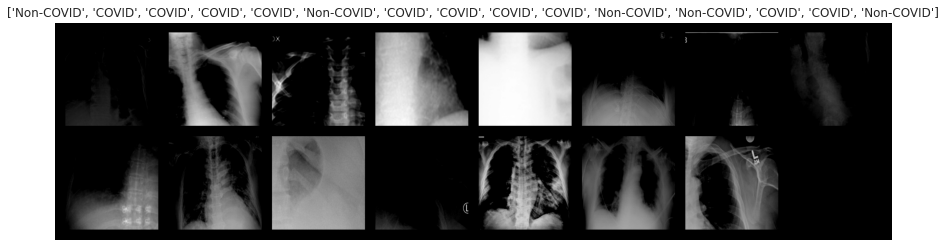

In [58]:

def imshow(img, title):
    npimg = img.numpy()
    plt.figure(figsize=(15, 7))
    plt.axis('off')
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.show()

def show_batch_images(dataloader):
    images, labels = next(iter(dataloader))
    img = torchvision.utils.make_grid(images, padding=25)
    imshow(img, title=["COVID" if x==0  else "Non-COVID" for x in labels])

train_loader, val_loader, test_loader = load_data()   
show_batch_images(train_loader)

In [59]:
def conv_output_volume(W, F, S, P):
    # your code here
    return int(((W - F + 2*P)/S)) + 1

print(conv_output_volume(W=224, F=3, S=3, P=0))
print(conv_output_volume(W=74, F=3, S=3, P=0))
print(conv_output_volume(W=24, F=3, S=3, P=0))
print(conv_output_volume(W=8, F=3, S=3, P=1))

74
24
8
3


CNN Definition


In [60]:
class CovidCNN(nn.Module):
    def __init__(self):
        super(CovidCNN, self).__init__()

        self.conv1 = nn.Sequential( 
            nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = (3,3), stride=(3,3), padding=0),
            nn.ReLU(inplace=True)
        )
                 
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = (3,3), stride=(3,3), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = (3,3), stride=(3,3), padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = (3,3), stride=(3,3), padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2, ceil_mode=True)
        )
         
        self.fc = nn.Linear(in_features = 128 * 1 * 1, out_features = 2)
        self.dropout = nn.Dropout()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        # x = torch.flatten(x,start_dim=1,end_dim=-1)
        x = x.view(x.shape[0], -1)
        
        x = self.fc(x)
        x = self.dropout(x)
        x = self.sigmoid(x)
        return x


In [61]:
def get_CoroNet_model():
    
    model = timm.create_model('xception', pretrained=True)
    num_classes = 2

    # replace the last layer
    num_ftrs  = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(0.5),
        nn.Linear(num_ftrs , 256),
        nn.ReLU(inplace=True),
        nn.Linear(256 , num_classes),
        nn.Softmax(-1)
    )
    
    return model

In [62]:
class EMCNet(nn.Module):
    def __init__(self):
        super(EMCNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=(1,1))
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 128, 3, padding=(1,1))
        self.conv3 = nn.Conv2d(128, 64, 3)
        self.conv4 = nn.Conv2d(64, 128, 3)
        self.conv5 = nn.Conv2d(128, 512, 3)
        self.conv6 = nn.Conv2d(512, 512, 3)
        self.fc1 = nn.Linear(12800, 64)
        self.fc2 = nn.Linear(64, 2)
        self.dropout = nn.Dropout(p=0.25)
        self.dropout1 = nn.Dropout(p=0.5)
        self.sigmoid = nn.Sigmoid()
        

    def forward(self, x):

        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv3(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv4(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv5(x)))
        x = self.dropout(x)
        x = self.pool(F.relu(self.conv6(x)))
        x = self.dropout(x)
        x = x.view(-1, 12800)
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc2(x))
        return x



Validations

Criterion and Optimizer

In [63]:
def get_model(model_nm = MODEL_NAME):
  if model_nm == 'CoroNet':
    model = get_CoroNet_model()
  elif model_nm == 'CovidCNN':
    model = CovidCNN()
  elif model_nm == 'EMCNet':
    model = EMCNet()
  
  if use_cuda:
    model.cuda()

  return model


criterion = None
optimizer = None

model = get_model(MODEL_NAME)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

if use_cuda:
    criterion = criterion.cuda()


Training

In [64]:
def save_checkpoint(model_state, checkpoint_path):
  torch.save(model_state, checkpoint_path)
  # if is_best:
  #   torch.save(model.state_dict(), filepath)
  #   # shutil.copyfile(filename, 'model_best.pth.tar')

def plot_metrics(train_losses, train_accuracy, val_losses, val_accuracy):

  epoch_list=  list(range(1, NUM_EPOCHS+1))

  sns.set_style("darkgrid")
  plt.plot(epoch_list, val_losses, label='Validation Loss')
  plt.plot(epoch_list, val_accuracy, label='Validation Accuracy')
  plt.title('Accuracy/Training Loss over epochs')
  plt.ylabel('Accuracy/Loss')
  plt.xlabel('Epoch')
  plt.ylim([0, 1])
  plt.legend(['Validation Loss', 'Validation Accuracy'], loc='lower right')
  plt.show()

def train_model(model, train_dataloader, val_dataloader, n_epoch=NUM_EPOCHS, optimizer=optimizer, criterion=criterion):

    model.train() # prep model for training
    
    train_losses = []
    val_losses = []
    train_accuracy = []
    val_accuracy = []
    min_val_accuracy = 0.0
    
    tb = SummaryWriter()

    for epoch in range(n_epoch):

      running_train_loss = 0
      running_val_loss = 0
      running_train_correct = 0
      running_val_correct = 0

      # Training loop
      for images, labels in train_dataloader:

        if use_cuda:
            images, labels = images.cuda(), labels.cuda()

        # Clear parameter gradients
        optimizer.zero_grad()

        # forward pass
        outputs = model(images)
        
        #Calculate loss
        loss = criterion(outputs, labels )

        # Loss for batch
        running_train_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)

        # backward pass
        loss.backward()
        
        #Perform single optimization step
        optimizer.step()

        # Correct predictions
        running_train_correct += (preds == labels).sum().item()

      # Validation loop
      for images, labels in val_dataloader:
        if use_cuda:
            images, labels = images.cuda(), labels.cuda()
        
        # Eval mode
        model.eval()
        
        output = model(images)
        loss = criterion(output, labels)
        _, preds = torch.max(output, 1)

        # Calculate validation loss and correct predictions
        running_val_loss += loss.item() * images.size(0)
        running_val_correct += (preds == labels).sum().item()
      
      # Put back in train mode for next epoch
      model.train()
  
      # Calculate loss and accuracy for training and validation
      epoch_train_loss = running_train_loss / len(train_dataloader.dataset)
      epoch_train_accuracy = running_train_correct / len(train_dataloader.dataset)
      epoch_val_loss = running_val_loss / len(val_dataloader.dataset)
      epoch_val_accuracy = running_val_correct / len(val_dataloader.dataset)

      print(
          f"Epoch {epoch+1}, Train loss : {epoch_train_loss:.4f}, Validation loss :{epoch_val_loss:.4f}, "
          f"Training accuracy: {epoch_train_accuracy:.4f}, Validation accuracy: {epoch_val_accuracy:.4f}"
          )
      
      # Arrays having values from all epochs for plotting graphs
      train_losses.append(epoch_train_loss)
      train_accuracy.append(epoch_train_accuracy)
      val_losses.append(epoch_val_loss)
      val_accuracy.append(epoch_val_accuracy)

      # Save the checkpoint after every epoch so that if needed, training can be resumed from this point later on
      checkpoint_path = MODEL_PATH + 'last_model_state.pth'
      save_checkpoint({
          'epoch': epoch,
          'state_dict': model.state_dict(),
          'optimizer' : optimizer.state_dict(),
          'loss': criterion,
          'epoch_val_accuracy': epoch_val_accuracy
      }, checkpoint_path)
      
      # If validation accuracy improves, save it so that he best model can be picked up at the end
      if epoch_val_accuracy > min_val_accuracy:
          print(f"Validation accuracy increased from {min_val_accuracy} -> {epoch_val_accuracy}. Saving model...")
          min_val_accuracy = epoch_val_accuracy
          file_path = MODEL_PATH + 'best_model_epoch' + str(epoch+1) + "_accuracy" + str(epoch_val_accuracy) + '.pth'
          torch.save(copy.deepcopy(model.state_dict()), file_path)

      # Remove previously saved models except the last checkpoint and best model
      for fpath in glob.glob(MODEL_PATH + '*.*') :
        if fpath not in [file_path,checkpoint_path]:
          os.remove(fpath)
          # print(fpath)

      # Log the epoch loss and accuracy for validation using TensorBoard
      if new_dataset != 'MINI':
        tb.add_scalar('Validation Loss', epoch_val_loss, epoch)
        tb.add_scalar('Validation Accuracy', epoch_val_accuracy, epoch)

    # Retrieve best model
    model = get_model(MODEL_NAME)
    model.load_state_dict(torch.load(file_path))
    
    return model, train_losses, train_accuracy, val_losses, val_accuracy


Epoch 1, Train loss : 0.7023, Validation loss :0.6932, Training accuracy: 0.5000, Validation accuracy: 0.5000
Validation accuracy increased from 0.0 -> 0.5. Saving model...
Epoch 2, Train loss : 0.6940, Validation loss :0.6931, Training accuracy: 0.4600, Validation accuracy: 0.5000
Epoch 3, Train loss : 0.6911, Validation loss :0.6928, Training accuracy: 0.5600, Validation accuracy: 0.5000
Epoch 4, Train loss : 0.6977, Validation loss :0.6921, Training accuracy: 0.5000, Validation accuracy: 0.5000
Epoch 5, Train loss : 0.6926, Validation loss :0.6921, Training accuracy: 0.4600, Validation accuracy: 0.4375
Epoch 6, Train loss : 0.6946, Validation loss :0.6921, Training accuracy: 0.5000, Validation accuracy: 0.5625
Validation accuracy increased from 0.5 -> 0.5625. Saving model...
Epoch 7, Train loss : 0.6883, Validation loss :0.6914, Training accuracy: 0.6000, Validation accuracy: 0.5625
Epoch 8, Train loss : 0.6901, Validation loss :0.6870, Training accuracy: 0.5200, Validation accuracy

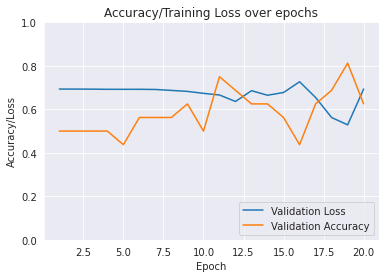

In [65]:
# get train and val data loader
train_loader, val_loader, test_loader = load_data()

seed = 24
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

# Load Tensorboard for live visualizations
if new_dataset != 'MINI':
  %load_ext tensorboard
  %tensorboard --logdir runs

model, train_losses, train_accuracy, val_losses, val_accuracy = train_model(model, train_loader, val_loader)

# Plot various metrics
plot_metrics(train_losses, train_accuracy, val_losses, val_accuracy)

In [66]:
def eval_model(model, dataloader):

  model.eval()

  Y_pred = []
  Y_test = []

  with torch.no_grad():
      correct = 0
      total = 0
      for images, labels in dataloader:
          if use_cuda:
            images, labels = images.cuda(), labels.cuda()
          y_pred = model(images)
          _, y_pred_tag = torch.max(y_pred, 1)
          # total += labels.size(0)
          # correct += (y_pred_tag == labels).sum().item()

          Y_pred = np.append(Y_pred,y_pred_tag.cpu().detach().numpy())
          Y_test = np.append(Y_test,labels.cpu().numpy())

      # print('Test Accuracy of the model: {} %'.format((correct / total) * 100))

  return Y_pred, Y_test

Accuracy: 0.7777777777777778 
Precision: 0.7922077922077921 
Recall: 0.7777777777777777 
F1: 0.7749999999999999 
Support: None
[[8 1]
 [3 6]]


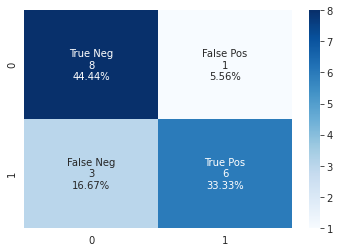

In [67]:
  from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix

  y_pred, y_true = eval_model(model, test_loader)

  # Print metrics
  accuracy = accuracy_score(y_true, y_pred)
  precision, recall, fscore, support = precision_recall_fscore_support(y_true, y_pred
                                                                       , average='macro'
                                                                      #  , pos_label = 0
                                                                      )
  print(f"Accuracy: {accuracy} \nPrecision: {precision} \nRecall: {recall} \nF1: {fscore} \nSupport: {support}")

  # Show confusion matrix
  np.set_printoptions(threshold=np.inf) 
  cm1 = confusion_matrix(y_true, y_pred)
  print(cm1)

  group_names = ['True Neg','False Pos','False Neg','True Pos']
  group_counts = ["{0:0.0f}".format(value) for value in
                  cm1.flatten()]
  group_percentages = ["{0:.2%}".format(value) for value in
                      cm1.flatten()/np.sum(cm1)]
  labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
  labels = np.asarray(labels).reshape(2,2)
  sns.heatmap(cm1, annot=labels, fmt='', cmap='Blues')



In [68]:

model_filename = MODEL_NAME + '_' + str(accuracy)+ '.pth'
torch.save(model.state_dict(), model_filename)

# download checkpoint file
files.download(model_filename)

# model.load_state_dict(torch.load(path))

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>